# VQVAE For Accent Reconstruction

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import random
import pickle
from tqdm import tqdm
import shutil

In [ ]:
# ==========================
# CONFIG & DEVICE SETUP
# ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/L2_ARCTIC_SUBSET"
FIXED_LENGTH = 5.0  # seconds
SR = 16000
N_MELS = 128
N_FFT = 1024
HOP_LENGTH = 256
MAX_FILES_PER_SPK = 500
SELECTED_SPEAKERS = ["HJK", "BWC", "YBAA", "SVBI", "THV"]
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 2e-4

✅ Using device: cuda


In [ ]:
# ==========================
# LOAD METADATA
# ==========================
def load_metadata(dataset_path, selected_speakers, max_files_per_spk):
    metadata = []
    for speaker in selected_speakers:
        wav_dir = os.path.join(dataset_path, speaker, "wav")
        if not os.path.isdir(wav_dir):
            continue
        files = [f for f in os.listdir(wav_dir) if f.endswith(".wav")]
        files = random.sample(files, min(len(files), max_files_per_spk))
        for file in files:
            metadata.append({"file_path": os.path.join(wav_dir, file), "speaker_id": speaker})
    return metadata

metadata = load_metadata(DATASET_PATH, SELECTED_SPEAKERS, MAX_FILES_PER_SPK)
train_meta, val_meta = train_test_split(metadata, test_size=0.2, random_state=42)

In [ ]:
# ==========================
# MEL FEATURE EXTRACTION
# ==========================
def extract_mel(file_path):
    y, _ = librosa.load(file_path, sr=SR)
    y = librosa.util.fix_length(y, size=int(SR * FIXED_LENGTH))
    S = librosa.feature.melspectrogram(y=y, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
    S_db = librosa.power_to_db(S, ref=np.max)
    # Normalize to [-1, 1]
    S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min()) * 2 - 1
    return torch.tensor(S_norm).unsqueeze(0), y, S_db.min(), S_db.max()



In [ ]:
MEL_CACHE_DIR = "/content/drive/MyDrive/Colab Notebooks/L2_ARCTIC_MEL_CACHE"
# Delete if exists
if os.path.exists(MEL_CACHE_DIR):
    print(f"⚠️ Deleting existing cache folder: {MEL_CACHE_DIR}")
    shutil.rmtree(MEL_CACHE_DIR)

os.makedirs(MEL_CACHE_DIR, exist_ok=True)

def cache_mel_spectrograms(metadata, cache_dir):
    for entry in tqdm(metadata, desc="Caching mel features"):
        wav_path = entry["file_path"]
        speaker = entry["speaker_id"]
        uid = Path(wav_path).stem
        cache_path = os.path.join(cache_dir, f"{speaker}_{uid}.pkl")
        if not os.path.exists(cache_path):
            mel, wav, mel_min, mel_max = extract_mel(wav_path)
            with open(cache_path, "wb") as f:
                pickle.dump({
                    "mel": mel,
                    "wav": wav,
                    "mel_min": mel_min,
                    "mel_max": mel_max
                }, f)

cache_mel_spectrograms(train_meta + val_meta, MEL_CACHE_DIR)

Caching mel features: 100%|██████████| 2500/2500 [25:12<00:00,  1.65it/s]


In [ ]:
# ==========================
# DATASET
# ==========================
class MelDataset(Dataset):
    def __init__(self, metadata, cache_dir):
        self.metadata = metadata
        self.cache_dir = cache_dir

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        entry = self.metadata[idx]
        wav_path = entry["file_path"]
        speaker = entry["speaker_id"]
        uid = Path(wav_path).stem
        cache_path = os.path.join(self.cache_dir, f"{speaker}_{uid}.pkl")
        with open(cache_path, "rb") as f:
            data = pickle.load(f)
        return data["mel"], data["mel"], data["wav"], data["mel_min"], data["mel_max"]

train_ds = MelDataset(train_meta, MEL_CACHE_DIR)
val_ds = MelDataset(val_meta, MEL_CACHE_DIR)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=1)

In [ ]:
# ==========================
# MODEL ARCHITECTURE
# ==========================
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels // 2, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(channels // 2, channels, 1, 1, 0),
            nn.ReLU()
        )

    def forward(self, x):
        return x + self.net(x)

class Encoder(nn.Module):
    def __init__(self, in_channels=1, hidden=128, latent_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, hidden, 4, 2, 1),  # Downsample 2x
            nn.ReLU(),
            ResidualBlock(hidden),
            nn.Conv2d(hidden, hidden, 4, 2, 1),  # Downsample 2x
            nn.ReLU(),
            ResidualBlock(hidden),
            nn.Conv2d(hidden, latent_dim, 3, 1, 1),  # Map to latent dim
        )

    def forward(self, x):
        return self.net(x)

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings=512, embedding_dim=64, beta=0.25):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.beta = beta
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

    def forward(self, x):
        B, C, H, W = x.shape
        x_flat = x.permute(0, 2, 3, 1).contiguous().view(-1, C)
        distances = (
            x_flat.pow(2).sum(1, keepdim=True)
            - 2 * x_flat @ self.embeddings.weight.t()
            + self.embeddings.weight.pow(2).sum(1)
        )
        indices = distances.argmin(1).unsqueeze(1)
        encodings = torch.zeros(indices.size(0), self.num_embeddings, device=x.device)
        encodings.scatter_(1, indices, 1)
        quantized = encodings @ self.embeddings.weight
        quantized = quantized.view(B, H, W, C).permute(0, 3, 1, 2)
        loss = self.beta * F.mse_loss(quantized.detach(), x) + F.mse_loss(quantized, x.detach())
        quantized = x + (quantized - x).detach()
        return quantized, loss

class Decoder(nn.Module):
    def __init__(self, latent_dim=64, hidden=128, out_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(latent_dim, hidden, 3, 1, 1),
            nn.ReLU(),
            ResidualBlock(hidden),
            nn.ConvTranspose2d(hidden, hidden, 4, 2, 1),  # Upsample 2x
            nn.ReLU(),
            ResidualBlock(hidden),
            nn.ConvTranspose2d(hidden, out_channels, 4, 2, 1),  # Upsample 2x
        )

    def forward(self, x):
        return self.net(x)

class VQVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.vq = VectorQuantizer()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        z_q, vq_loss = self.vq(z)
        x_hat = self.decoder(z_q)
        return x_hat, vq_loss

🎯 Epoch 1/50 | Loss: 65.3271 | Recon: 0.1780 | VQ: 65.1491
🎯 Epoch 2/50 | Loss: 2.5450 | Recon: 0.2346 | VQ: 2.3104
🎯 Epoch 3/50 | Loss: 0.6546 | Recon: 0.2140 | VQ: 0.4406
🎯 Epoch 4/50 | Loss: 7.2721 | Recon: 0.0920 | VQ: 7.1801
🎯 Epoch 5/50 | Loss: 12.2724 | Recon: 0.0693 | VQ: 12.2031
🎯 Epoch 6/50 | Loss: 4.2681 | Recon: 0.0533 | VQ: 4.2148
🎯 Epoch 7/50 | Loss: 1.0411 | Recon: 0.0390 | VQ: 1.0021
🎯 Epoch 8/50 | Loss: 0.6473 | Recon: 0.0335 | VQ: 0.6138
🎯 Epoch 9/50 | Loss: 0.3563 | Recon: 0.0292 | VQ: 0.3271
🎯 Epoch 10/50 | Loss: 0.2547 | Recon: 0.0269 | VQ: 0.2277
🎯 Epoch 11/50 | Loss: 0.1441 | Recon: 0.0241 | VQ: 0.1200
🎯 Epoch 12/50 | Loss: 0.0716 | Recon: 0.0220 | VQ: 0.0496
🎯 Epoch 13/50 | Loss: 0.0560 | Recon: 0.0212 | VQ: 0.0349
🎯 Epoch 14/50 | Loss: 0.0538 | Recon: 0.0203 | VQ: 0.0335
🎯 Epoch 15/50 | Loss: 0.0553 | Recon: 0.0192 | VQ: 0.0361
🎯 Epoch 16/50 | Loss: 0.0538 | Recon: 0.0181 | VQ: 0.0357
🎯 Epoch 17/50 | Loss: 0.0492 | Recon: 0.0171 | VQ: 0.0321
🎯 Epoch 18/50 | Los

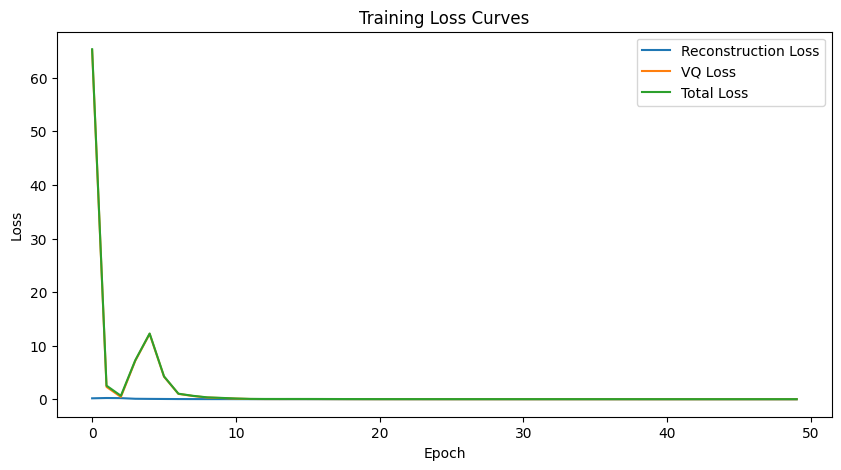

In [ ]:
# ==========================
# TRAINING LOOP
# ==========================
model = VQVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
losses = {"recon": [], "vq": [], "total": []}

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_vq_loss = 0

    for x, y, _, _, _ in train_loader:
        x = x.to(device).float()
        y = y.to(device).float()

        x_hat, vq_loss = model(x)

        # Ensure shapes match
        if x_hat.shape != y.shape:
            min_h = min(x_hat.shape[2], y.shape[2])
            min_w = min(x_hat.shape[3], y.shape[3])
            x_hat = x_hat[:, :, :min_h, :min_w]
            y = y[:, :, :min_h, :min_w]

        recon_loss = F.mse_loss(x_hat, y)
        loss = recon_loss + vq_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_vq_loss += vq_loss.item()

    scheduler.step()

    avg_loss = total_loss / len(train_loader)
    avg_recon = total_recon_loss / len(train_loader)
    avg_vq = total_vq_loss / len(train_loader)

    losses["recon"].append(avg_recon)
    losses["vq"].append(avg_vq)
    losses["total"].append(avg_loss)

    print(f"🎯 Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | VQ: {avg_vq:.4f}")

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(losses["recon"], label="Reconstruction Loss")
plt.plot(losses["vq"], label="VQ Loss")
plt.plot(losses["total"], label="Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Curves")
plt.show()


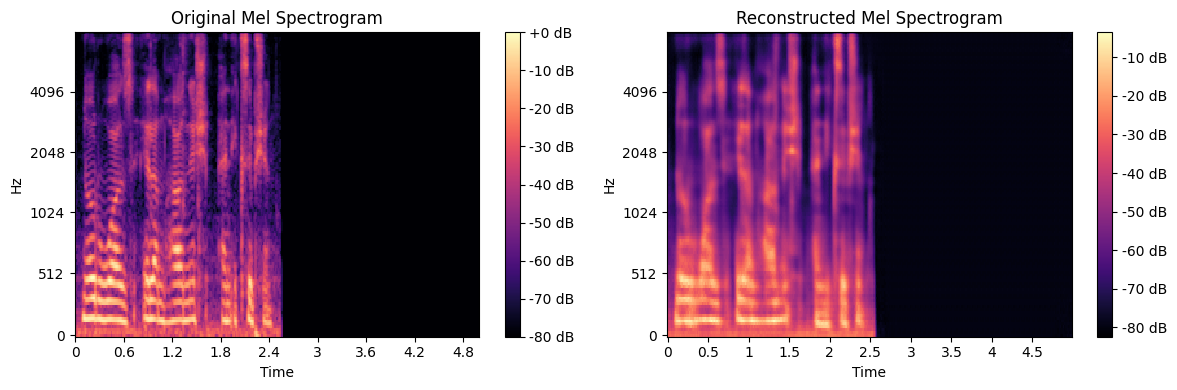


▶️ Original Audio:



🔁 Reconstructed Audio:


In [ ]:
# ==========================
# EVALUATION WITH AUDIO OUTPUT
# ==========================
model.eval()
x, y, wav, mel_min, mel_max = next(iter(val_loader))
x = x.to(device).float()
x_hat, _ = model(x)

# Denormalize for visualization and audio
mel_recon = x_hat[0, 0].detach().cpu().numpy()
mel_orig = x[0, 0].cpu().numpy()
# Convert back to dB scale
mel_min = mel_min.item()  # Convert tensor to scalar
mel_max = mel_max.item()  # Convert tensor to scalar
mel_recon_db = (mel_recon + 1) / 2 * (mel_max - mel_min) + mel_min
mel_orig_db = (mel_orig + 1) / 2 * (mel_max - mel_min) + mel_min
# Convert to power for audio synthesis
melspec = librosa.db_to_power(mel_recon_db)
y_hat = librosa.feature.inverse.mel_to_audio(melspec, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH)

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(mel_orig_db, sr=SR, hop_length=HOP_LENGTH, y_axis='mel', x_axis='time')
plt.title("Original Mel Spectrogram")
plt.colorbar(format='%+2.0f dB')
plt.subplot(1, 2, 2)
librosa.display.specshow(mel_recon_db, sr=SR, hop_length=HOP_LENGTH, y_axis='mel', x_axis='time')
plt.title("Reconstructed Mel Spectrogram")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

print("\n▶️ Original Audio:")
ipd.display(ipd.Audio(wav[0], rate=SR))
print("\n🔁 Reconstructed Audio:")
ipd.display(ipd.Audio(y_hat, rate=SR))